<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/coal_xg%2Bxg_insam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2017-01-01

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import date, datetime
import datetime
from google.colab import drive
drive.mount('/content/drive/')

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/유연탄 데이터/project/final_df_using_XGB_2017-01-01.csv")
train_end_time = datetime.date(2016, 12, 31)
test_split_date = '2016-12-31'

In [ ]:
df

,Unnamed: 0,Next_Coal,Coal,Iron,Brent_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,ASX,TSX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E
0,2011-01-01,122.65,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
1,2011-01-02,136.50,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
2,2011-01-03,137.30,136.50,170.000000,94.840000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,4745.200195,13443.200195,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932
3,2011-01-04,130.65,137.30,172.100000,93.530000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,4742.500000,13402.299805,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922
4,2011-01-05,133.15,130.65,174.500000,95.500000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,4714.899902,13396.000000,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,2017-03-28,80.75,80.75,83.643297,51.408584,51.543737,50.580376,54.815250,982.564749,1.389465,...,7228.753391,11644.721789,5703.004401,15305.355004,2276.547777,21778.433495,5456.265894,2025.931693,18968.140872,3309.836410
2279,2017-03-29,80.70,80.75,83.688048,51.346383,51.518722,50.542335,54.828874,982.812620,1.389549,...,7229.741364,11646.602963,5703.432040,15305.559089,2276.981314,21775.880310,5457.106650,2025.925621,18966.460087,3310.058438
2280,2017-03-30,80.75,80.70,83.732798,51.284183,51.493708,50.504293,54.842497,983.060491,1.389632,...,7230.729336,11648.484138,5703.859679,15305.763174,2277.414850,21773.327126,5457.947406,2025.919549,18964.779302,3310.280465
2281,2017-03-31,80.75,80.75,83.777549,51.221983,51.468693,50.466251,54.856121,983.308362,1.389716,...,7231.717308,11650.365313,5704.287318,15305.967259,2277.848387,21770.773941,5458.788162,2025.913477,18963.098517,3310.502493


In [ ]:
col_names = df.columns
df['date'] = pd.to_datetime(df[col_names[0]])
df = df.set_index(df['date'])
df = df.drop(['date'],axis = 1)
df = df.drop([col_names[0]],axis = 1)
index = df.index
col_names = df.columns

In [ ]:
period = 90
day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)


test_end_time = train_end_time+ datetime.timedelta(period)
train_end_time = f'{train_end_time.year}-{train_end_time.month}-{train_end_time.day}'
test_end_time = f'{test_end_time.year}-{test_end_time.month}-{test_end_time.day}'
test_end_time = pd.date_range(train_end_time,test_end_time, freq=day_freq)

df = df.loc[df.index <= test_end_time[-1]].copy()

In [ ]:
def create_features(df, label):
    X = df.drop(label, axis = 1)
    y = df[label]
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

In [ ]:
df_X, df_y = create_features(df, col_names[0])
df_y_rate = pd.DataFrame({"y_rate" : ((df_y[col_names[0]]-df_X[col_names[1]])/df_X[col_names[1]])}, index = df_y.index)

#val_split_date = '2017-12-31'
train_X = df_X.loc[df_X.index < test_split_date].copy()
#val_X = train_X.loc[train_X.index > val_split_date].copy()
#train_X = train_X.loc[train_X.index <= val_split_date].copy()
test_X = df_X.loc[df_X.index >= test_split_date].copy()

train_y_rate = df_y_rate.loc[df_y_rate.index < test_split_date].copy()
#val_y_rate = train_y_rate.loc[train_y_rate.index > val_split_date].copy()
#train_y_rate = train_y_rate.loc[train_y_rate.index <= val_split_date].copy()
test_y_rate = df_y_rate.loc[df_y_rate.index >= test_split_date].copy()


train_y = df_y.loc[df_y.index < test_split_date].copy()
test_y = df_y.loc[df_y.index >= test_split_date].copy()



In [ ]:
reg = xgb.XGBRegressor(learning_rate=0.4,max_depth=5,n_estimators=90)
reg.fit(train_X, train_y_rate,
        eval_set=[(train_X, train_y_rate), (test_X, test_y_rate)],
        early_stopping_rounds=100,
        verbose=False)

[00:13:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.4, max_depth=5, n_estimators=90)

In [ ]:
df_y_pred = test_X.head(1)
for i in range(len(test_end_time)-1):
  y_pred = reg.predict(df_y_pred.tail(1))
  y_pred = (1*y_pred+1)*df_y_pred[col_names[1]].tail(1)
  _ = df_y_pred.tail(1).index+datetime.timedelta(days=1)
  _ = pd.date_range(_[0],periods = 1, freq = day_freq)
  frame = pd.DataFrame({col_names[1]:y_pred[0]},index = _)
  q = test_X.loc[test_X.index[i+1]]
  q = pd.DataFrame(q)
  q = q.T.drop('Coal',axis = 1)
  q = pd.concat([frame, q], axis=1)
  df_y_pred = df_y_pred.append(q)

            Next_Coal       Coal
2016-12-31      88.40  88.400000
2017-01-01      88.40  88.444408
2017-01-02      90.50  88.488837
2017-01-03      88.60  88.533290
2017-01-04      85.70  88.577764
...               ...        ...
2017-03-27      80.75  75.070275
2017-03-28      80.75  75.239708
2017-03-29      80.70  75.484049
2017-03-30      80.75  75.729183
2017-03-31      80.75  75.975114

[91 rows x 2 columns]


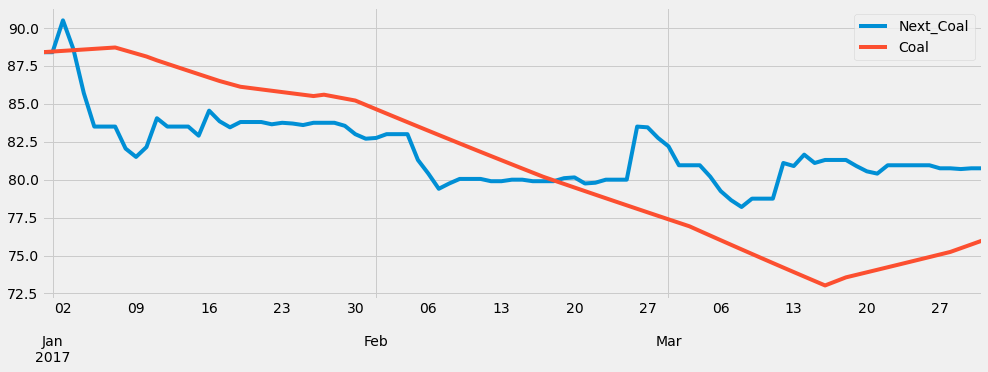

In [ ]:
_ = pd.concat([test_y, df_y_pred['Coal']], axis=1)
#_ = pd.concat([train_y,  _],axis = 1)
print(_)
_ = _.plot(figsize=(15, 5))

# 2017-04-01

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import date, datetime
import datetime
from google.colab import drive
drive.mount('/content/drive/')

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/유연탄 데이터/project/final_df_using_XGB_2017-04-01.csv")
train_end_time = datetime.date(2017, 3, 31)
test_split_date = '2017-03-31'

In [ ]:
df

,Unnamed: 0,Next_Coal,Coal,Iron,Brent_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,ASX,TSX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E
0,2011-01-01,122.65,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
1,2011-01-02,136.50,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
2,2011-01-03,137.30,136.50,170.000000,94.840000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,4745.200195,13443.200195,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932
3,2011-01-04,130.65,137.30,172.100000,93.530000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,4742.500000,13402.299805,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922
4,2011-01-05,133.15,130.65,174.500000,95.500000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,4714.899902,13396.000000,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368,2017-06-26,80.60,80.55,84.033873,49.044027,46.272299,46.466852,39.864381,1301.993109,1.310762,...,7353.886811,11993.017420,5870.733448,15488.551503,2400.808152,24045.269628,5985.673067,2155.500118,18753.223155,3495.180580
2369,2017-06-27,80.65,80.60,84.001618,49.000510,46.890263,46.304680,39.866845,1302.050501,1.311392,...,7354.242983,11994.317033,5869.817654,15490.182086,2401.245948,24044.507327,5986.522870,2155.737999,18751.429630,3495.114495
2370,2017-06-28,80.95,80.65,83.969364,48.956993,46.830846,46.385251,39.869309,1302.107893,1.312021,...,7354.599154,11995.616646,5868.901859,15491.812670,2401.683743,24043.745026,5987.372672,2155.975881,18749.636106,3495.048411
2371,2017-06-29,81.00,80.95,83.937110,48.913476,46.771429,46.465822,39.871773,1302.165285,1.310088,...,7354.955326,11996.916258,5867.986065,15493.443253,2402.121538,24042.982724,5988.222475,2156.213763,18747.842582,3494.982326


In [ ]:
col_names = df.columns
df['date'] = pd.to_datetime(df[col_names[0]])
df = df.set_index(df['date'])
df = df.drop(['date'],axis = 1)
df = df.drop([col_names[0]],axis = 1)
index = df.index
col_names = df.columns

In [ ]:
period = 90
day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)


test_end_time = train_end_time+ datetime.timedelta(period)
train_end_time = f'{train_end_time.year}-{train_end_time.month}-{train_end_time.day}'
test_end_time = f'{test_end_time.year}-{test_end_time.month}-{test_end_time.day}'
test_end_time = pd.date_range(train_end_time,test_end_time, freq=day_freq)

df = df.loc[df.index <= test_end_time[-1]].copy()

In [ ]:
def create_features(df, label):
    X = df.drop(label, axis = 1)
    y = df[label]
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

In [ ]:
df_X, df_y = create_features(df, col_names[0])
df_y_rate = pd.DataFrame({"y_rate" : ((df_y[col_names[0]]-df_X[col_names[1]])/df_X[col_names[1]])}, index = df_y.index)

#val_split_date = '2017-12-31'
train_X = df_X.loc[df_X.index < test_split_date].copy()
#val_X = train_X.loc[train_X.index > val_split_date].copy()
#train_X = train_X.loc[train_X.index <= val_split_date].copy()
test_X = df_X.loc[df_X.index >= test_split_date].copy()

train_y_rate = df_y_rate.loc[df_y_rate.index < test_split_date].copy()
#val_y_rate = train_y_rate.loc[train_y_rate.index > val_split_date].copy()
#train_y_rate = train_y_rate.loc[train_y_rate.index <= val_split_date].copy()
test_y_rate = df_y_rate.loc[df_y_rate.index >= test_split_date].copy()


train_y = df_y.loc[df_y.index < test_split_date].copy()
test_y = df_y.loc[df_y.index >= test_split_date].copy()



In [ ]:
reg = xgb.XGBRegressor(learning_rate=0.4,max_depth=5,n_estimators=90)
reg.fit(train_X, train_y_rate,
        eval_set=[(train_X, train_y_rate), (test_X, test_y_rate)],
        early_stopping_rounds=100,
        verbose=False)

[00:15:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.4, max_depth=5, n_estimators=90)

In [ ]:
test_X.index[0]

Timestamp('2017-03-31 00:00:00')

In [ ]:
df_y_pred = test_X.head(1)
for i in range(len(test_end_time)-1):
  y_pred = reg.predict(df_y_pred.tail(1))
  y_pred = (1*y_pred+1)*df_y_pred[col_names[1]].tail(1)
  _ = df_y_pred.tail(1).index+datetime.timedelta(days=1)
  _ = pd.date_range(_[0],periods = 1, freq = day_freq)
  frame = pd.DataFrame({col_names[1]:y_pred[0]},index = _)
  q = test_X.loc[test_X.index[i+1]]
  q = pd.DataFrame(q)
  q = q.T.drop('Coal',axis = 1)
  q = pd.concat([frame, q], axis=1)
  df_y_pred = df_y_pred.append(q)

            Next_Coal       Coal
2017-03-31      80.75  80.750000
2017-04-01      80.75  80.837867
2017-04-02      89.50  80.925831
2017-04-03      89.75  81.013889
2017-04-04      89.45  81.102044
...               ...        ...
2017-06-25      80.55  87.249099
2017-06-26      80.60  87.344039
2017-06-27      80.65  87.439082
2017-06-28      80.95  87.534228
2017-06-29      81.00  87.629478

[91 rows x 2 columns]


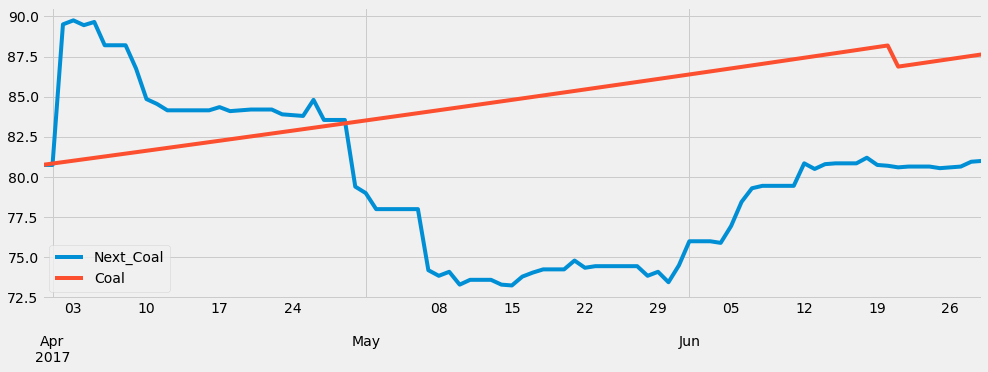

In [ ]:
_ = pd.concat([test_y, df_y_pred['Coal']], axis=1)
#_ = pd.concat([train_y,  _],axis = 1)
print(_)
_ = _.plot(figsize=(15, 5))

# 2017-07-01

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import date, datetime
import datetime
from google.colab import drive
drive.mount('/content/drive/')

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/유연탄 데이터/project/final_df_using_XGB_2017-07-01.csv")
train_end_time = datetime.date(2017, 6, 30)
test_split_date = '2017-06-30'

In [ ]:
df

,Unnamed: 0,Next_Coal,Coal,Iron,Brent_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,ASX,TSX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E
0,2011-01-01,122.65,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
1,2011-01-02,136.50,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
2,2011-01-03,137.30,136.50,170.000000,94.840000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,4745.200195,13443.200195,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932
3,2011-01-04,130.65,137.30,172.100000,93.530000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,4742.500000,13402.299805,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922
4,2011-01-05,133.15,130.65,174.500000,95.500000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,4714.899902,13396.000000,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,2017-09-25,97.00,96.95,68.535404,58.484643,50.646187,46.479577,46.265107,925.440131,1.308271,...,7325.720154,12331.240828,5755.675644,15258.530665,2461.935015,25393.184167,6233.891722,2381.519971,20227.859578,3444.884677
2460,2017-09-26,97.25,97.00,68.679374,58.604979,50.691285,46.394412,46.380798,925.721052,1.309123,...,7322.364438,12331.311181,5757.969606,15259.408026,2462.377832,25388.915249,6234.966110,2381.401924,20230.094404,3444.307023
2461,2017-09-27,97.10,97.25,68.823344,58.725316,50.736384,46.569556,46.496489,926.001973,1.308733,...,7319.008723,12331.381534,5754.137678,15260.285388,2462.820649,25384.646330,6236.040499,2381.283877,20232.329231,3443.729369
2462,2017-09-28,97.25,97.10,68.967315,58.845652,50.781482,46.484390,46.612180,926.282894,1.308344,...,7322.430056,12331.451887,5756.431640,15261.162750,2463.263466,25380.377412,6237.114887,2381.165831,20234.564057,3443.151715


In [ ]:
col_names = df.columns
df['date'] = pd.to_datetime(df[col_names[0]])
df = df.set_index(df['date'])
df = df.drop(['date'],axis = 1)
df = df.drop([col_names[0]],axis = 1)
df = df.drop('Iron',axis =1)

index = df.index
col_names = df.columns

In [ ]:
period = 90
day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)


test_end_time = train_end_time+ datetime.timedelta(period)
train_end_time = f'{train_end_time.year}-{train_end_time.month}-{train_end_time.day}'
test_end_time = f'{test_end_time.year}-{test_end_time.month}-{test_end_time.day}'
test_end_time = pd.date_range(train_end_time,test_end_time, freq=day_freq)

df = df.loc[df.index <= test_end_time[-1]].copy()

In [ ]:
def create_features(df, label):
    X = df.drop(label, axis = 1)
    y = df[label]
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

In [ ]:
df_X, df_y = create_features(df, col_names[0])
df_y_rate = pd.DataFrame({"y_rate" : ((df_y[col_names[0]]-df_X[col_names[1]])/df_X[col_names[1]])}, index = df_y.index)

#val_split_date = '2017-12-31'
train_X = df_X.loc[df_X.index < test_split_date].copy()
#val_X = train_X.loc[train_X.index > val_split_date].copy()
#train_X = train_X.loc[train_X.index <= val_split_date].copy()
test_X = df_X.loc[df_X.index >= test_split_date].copy()

train_y_rate = df_y_rate.loc[df_y_rate.index < test_split_date].copy()
#val_y_rate = train_y_rate.loc[train_y_rate.index > val_split_date].copy()
#train_y_rate = train_y_rate.loc[train_y_rate.index <= val_split_date].copy()
test_y_rate = df_y_rate.loc[df_y_rate.index >= test_split_date].copy()


train_y = df_y.loc[df_y.index < test_split_date].copy()
test_y = df_y.loc[df_y.index >= test_split_date].copy()



In [ ]:
reg = xgb.XGBRegressor(learning_rate=0.4,max_depth=5,n_estimators=90)
reg.fit(train_X, train_y_rate,
        eval_set=[(train_X, train_y_rate), (test_X, test_y_rate)],
        early_stopping_rounds=100,
        verbose=False)

[00:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.4, max_depth=5, n_estimators=90)

In [ ]:
test_X.index[0]

Timestamp('2017-06-30 00:00:00')

In [ ]:
df_y_pred = test_X.head(1)
for i in range(len(test_end_time)-1):
  y_pred = reg.predict(df_y_pred.tail(1))
  y_pred = (1*y_pred+1)*df_y_pred[col_names[1]].tail(1)
  _ = df_y_pred.tail(1).index+datetime.timedelta(days=1)
  _ = pd.date_range(_[0],periods = 1, freq = day_freq)
  frame = pd.DataFrame({col_names[1]:y_pred[0]},index = _)
  q = test_X.loc[test_X.index[i+1]]
  q = pd.DataFrame(q)
  q = q.T.drop('Coal',axis = 1)
  q = pd.concat([frame, q], axis=1)
  df_y_pred = df_y_pred.append(q)

            Next_Coal        Coal
2017-06-30      81.00   81.000000
2017-07-01      81.00   81.399950
2017-07-02      79.45   81.801874
2017-07-03      81.15   82.205783
2017-07-04      83.05   82.611686
...               ...         ...
2017-09-24      96.95  123.067636
2017-09-25      97.00  123.663578
2017-09-26      97.25  124.262407
2017-09-27      97.10  124.864135
2017-09-28      97.25  125.468777

[91 rows x 2 columns]


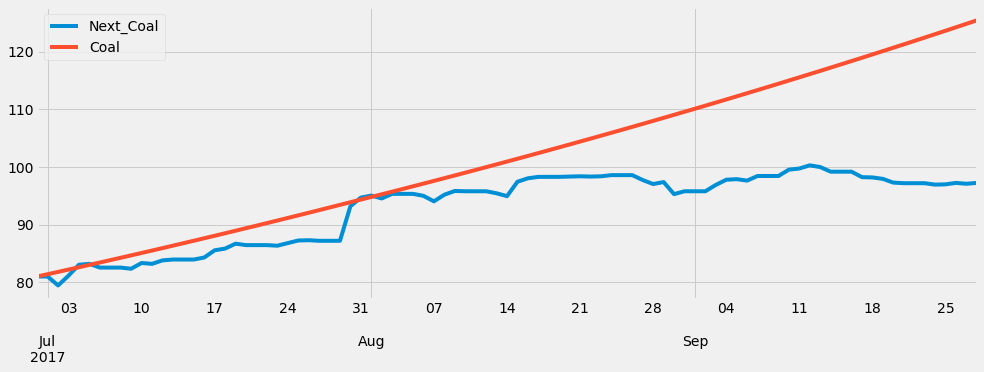

In [ ]:
_ = pd.concat([test_y, df_y_pred['Coal']], axis=1)
#_ = pd.concat([train_y,  _],axis = 1)
print(_)
_ = _.plot(figsize=(15, 5))

            Next_Coal       Coal
2017-06-30      81.00  81.000000
2017-07-01      81.00  81.553527
2017-07-02      79.45  82.110838
2017-07-03      81.15  82.671956
2017-07-04      83.05  83.236909
...               ...        ...
2017-09-24      96.95  98.878034
2017-09-25      97.00  98.375658
2017-09-26      97.25  98.784425
2017-09-27      97.10  99.194890
2017-09-28      97.25  99.607060

[91 rows x 2 columns]


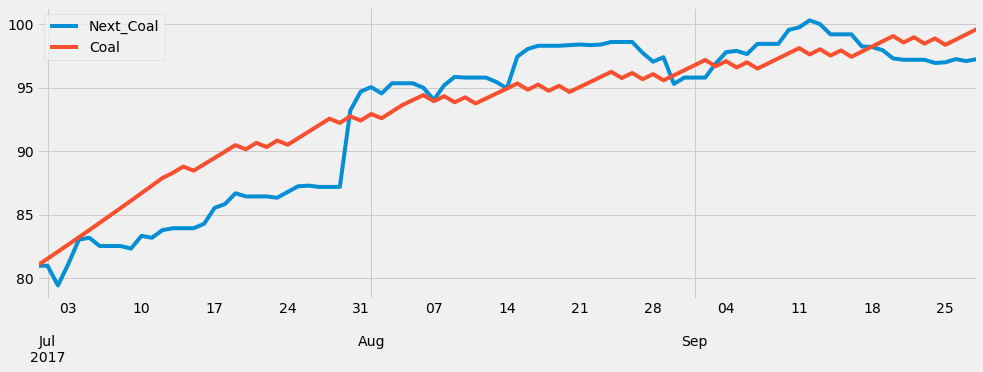

In [ ]:
_ = pd.concat([test_y, df_y_pred['Coal']], axis=1)
#_ = pd.concat([train_y,  _],axis = 1)
print(_)
_ = _.plot(figsize=(15, 5))

# 2017-10-01

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import date, datetime
import datetime
from google.colab import drive
drive.mount('/content/drive/')

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/유연탄 데이터/project/final_df_using_XGB_2017-10-01.csv")
train_end_time = datetime.date(2017, 9, 30)
test_split_date = '2017-09-30'

In [ ]:
df

,Unnamed: 0,Next_Coal,Coal,Iron,Brent_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,ASX,TSX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E
0,2011-01-01,122.65,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
1,2011-01-02,136.50,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
2,2011-01-03,137.30,136.50,170.000000,94.840000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,4745.200195,13443.200195,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932
3,2011-01-04,130.65,137.30,172.100000,93.530000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,4742.500000,13402.299805,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922
4,2011-01-05,133.15,130.65,174.500000,95.500000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,4714.899902,13396.000000,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,2017-12-26,100.20,100.20,65.470268,65.717936,59.638300,59.339126,57.765686,1387.641351,1.302212,...,7404.134162,12755.743133,5721.928126,15615.175271,2570.538193,27516.112971,6619.509571,2434.201743,20278.260245,3591.072160
2552,2017-12-27,101.20,100.20,65.420846,65.811935,59.729890,59.431070,57.885752,1388.005044,1.301327,...,7404.494327,12756.949906,5722.391666,15615.743266,2571.126447,27515.674031,6620.929682,2434.658430,20277.363474,3589.211040
2553,2017-12-28,100.80,101.20,65.371424,65.905935,59.821480,59.523014,58.005817,1388.368738,1.300442,...,7404.854492,12758.156679,5722.855207,15616.311261,2571.714701,27515.235090,6622.349792,2435.115117,20276.466703,3589.546302
2554,2017-12-29,100.80,100.80,65.322002,65.999934,59.913069,59.614958,58.125883,1388.732432,1.302519,...,7405.214657,12759.363452,5723.318748,15616.879256,2572.302954,27514.796150,6623.769903,2435.571804,20275.569932,3589.881564


In [ ]:
col_names = df.columns
df['date'] = pd.to_datetime(df[col_names[0]])
df = df.set_index(df['date'])
df = df.drop(['date'],axis = 1)
df = df.drop([col_names[0]],axis = 1)
index = df.index
col_names = df.columns

In [ ]:
period = 90
day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)


test_end_time = train_end_time+ datetime.timedelta(period)
train_end_time = f'{train_end_time.year}-{train_end_time.month}-{train_end_time.day}'
test_end_time = f'{test_end_time.year}-{test_end_time.month}-{test_end_time.day}'
test_end_time = pd.date_range(train_end_time,test_end_time, freq=day_freq)

df = df.loc[df.index <= test_end_time[-1]].copy()

In [ ]:
def create_features(df, label):
    X = df.drop(label, axis = 1)
    y = df[label]
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

In [ ]:
df_X, df_y = create_features(df, col_names[0])
df_y_rate = pd.DataFrame({"y_rate" : ((df_y[col_names[0]]-df_X[col_names[1]])/df_X[col_names[1]])}, index = df_y.index)

#val_split_date = '2017-12-31'
train_X = df_X.loc[df_X.index < test_split_date].copy()
#val_X = train_X.loc[train_X.index > val_split_date].copy()
#train_X = train_X.loc[train_X.index <= val_split_date].copy()
test_X = df_X.loc[df_X.index >= test_split_date].copy()

train_y_rate = df_y_rate.loc[df_y_rate.index < test_split_date].copy()
#val_y_rate = train_y_rate.loc[train_y_rate.index > val_split_date].copy()
#train_y_rate = train_y_rate.loc[train_y_rate.index <= val_split_date].copy()
test_y_rate = df_y_rate.loc[df_y_rate.index >= test_split_date].copy()


train_y = df_y.loc[df_y.index < test_split_date].copy()
test_y = df_y.loc[df_y.index >= test_split_date].copy()



In [ ]:
reg = xgb.XGBRegressor(learning_rate=0.4,max_depth=5,n_estimators=90)
reg.fit(train_X, train_y_rate,
        eval_set=[(train_X, train_y_rate), (test_X, test_y_rate)],
        early_stopping_rounds=100,
        verbose=False)

[07:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.4, max_depth=5, n_estimators=90)

In [ ]:
test_X.index[0]

Timestamp('2017-09-30 00:00:00')

In [ ]:
df_y_pred = test_X.head(1)
for i in range(len(test_end_time)-1):
  y_pred = reg.predict(df_y_pred.tail(1))
  y_pred = (1*y_pred+1)*df_y_pred[col_names[1]].tail(1)
  _ = df_y_pred.tail(1).index+datetime.timedelta(days=1)
  _ = pd.date_range(_[0],periods = 1, freq = day_freq)
  frame = pd.DataFrame({col_names[1]:y_pred[0]},index = _)
  q = test_X.loc[test_X.index[i+1]]
  q = pd.DataFrame(q)
  q = q.T.drop('Coal',axis = 1)
  q = pd.concat([frame, q], axis=1)
  df_y_pred = df_y_pred.append(q)

            Next_Coal        Coal
2017-09-30      97.25   97.250000
2017-10-01      95.90   97.673253
2017-10-02      97.00   98.098347
2017-10-03      99.00   98.525292
2017-10-04      98.65   98.954095
...               ...         ...
2017-12-25     100.20  106.754824
2017-12-26     100.20  106.853656
2017-12-27     101.20  106.952579
2017-12-28     100.80  107.051593
2017-12-29     100.80  107.150699

[91 rows x 2 columns]


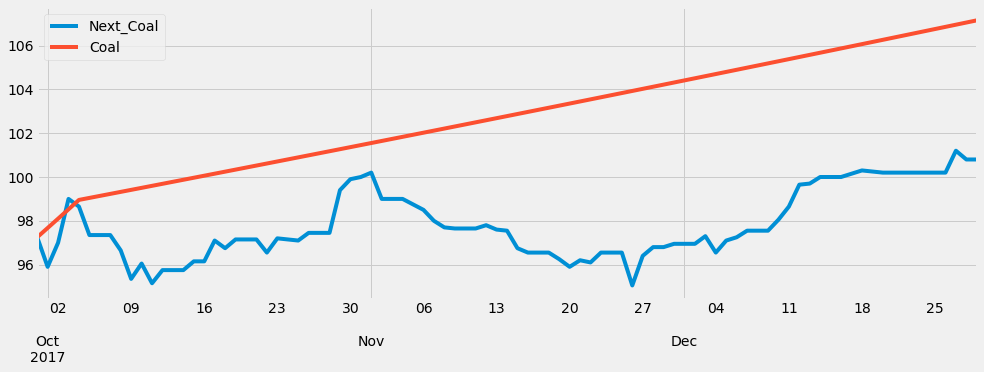

In [ ]:
_ = pd.concat([test_y, df_y_pred['Coal']], axis=1)
#_ = pd.concat([train_y,  _],axis = 1)
print(_)
_ = _.plot(figsize=(15, 5))

# 2018-01-01

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import date, datetime
import datetime
from google.colab import drive
drive.mount('/content/drive/')

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/유연탄 데이터/project/final_df_using_XGB_2018-01-01.csv")
train_end_time = datetime.date(2017, 12, 31)
test_split_date = '2017-12-31'

In [ ]:
df

,Unnamed: 0,Next_Coal,Coal,Iron,Brent_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,ASX,TSX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E
0,2011-01-01,122.65,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
1,2011-01-02,136.50,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
2,2011-01-03,137.30,136.50,170.000000,94.840000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,4745.200195,13443.200195,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932
3,2011-01-04,130.65,137.30,172.100000,93.530000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,4742.500000,13402.299805,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922
4,2011-01-05,133.15,130.65,174.500000,95.500000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,4714.899902,13396.000000,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643,2018-03-28,96.40,96.65,66.657962,69.952580,64.603253,64.750405,57.973754,1332.850677,1.308897,...,7658.425858,12881.247800,5938.544849,16021.404169,2683.637340,29942.536094,6869.984566,2473.140836,22564.950439,3494.023986
2644,2018-03-29,96.40,96.40,66.655624,69.988012,64.651336,64.802364,57.991499,1332.632560,1.308737,...,7657.697681,12880.829503,5927.770756,16027.011108,2684.469996,29949.730242,6873.047503,2474.975612,22589.331682,3493.909779
2645,2018-03-30,96.40,96.40,66.653285,70.023444,64.699419,64.854323,58.009243,1332.414444,1.308577,...,7656.969503,12880.411205,5933.144194,16022.684237,2685.302651,29956.924390,6871.764337,2476.810388,22613.712925,3493.795572
2646,2018-03-31,96.40,96.40,66.650947,70.058876,64.747503,64.906281,58.026987,1332.196327,1.308417,...,7656.241326,12879.992908,5938.517632,16028.291176,2686.135307,29964.118538,6870.481171,2472.118629,22555.525368,3493.681366


In [ ]:
col_names = df.columns
df['date'] = pd.to_datetime(df[col_names[0]])
df = df.set_index(df['date'])
df = df.drop(['date'],axis = 1)
df = df.drop([col_names[0]],axis = 1)
index = df.index
col_names = df.columns

In [ ]:
period = 90
day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)


test_end_time = train_end_time+ datetime.timedelta(period)
train_end_time = f'{train_end_time.year}-{train_end_time.month}-{train_end_time.day}'
test_end_time = f'{test_end_time.year}-{test_end_time.month}-{test_end_time.day}'
test_end_time = pd.date_range(train_end_time,test_end_time, freq=day_freq)

df = df.loc[df.index <= test_end_time[-1]].copy()

In [ ]:
def create_features(df, label):
    X = df.drop(label, axis = 1)
    y = df[label]
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

In [ ]:
df_X, df_y = create_features(df, col_names[0])
df_y_rate = pd.DataFrame({"y_rate" : ((df_y[col_names[0]]-df_X[col_names[1]])/df_X[col_names[1]])}, index = df_y.index)

#val_split_date = '2017-12-31'
train_X = df_X.loc[df_X.index < test_split_date].copy()
#val_X = train_X.loc[train_X.index > val_split_date].copy()
#train_X = train_X.loc[train_X.index <= val_split_date].copy()
test_X = df_X.loc[df_X.index >= test_split_date].copy()

train_y_rate = df_y_rate.loc[df_y_rate.index < test_split_date].copy()
#val_y_rate = train_y_rate.loc[train_y_rate.index > val_split_date].copy()
#train_y_rate = train_y_rate.loc[train_y_rate.index <= val_split_date].copy()
test_y_rate = df_y_rate.loc[df_y_rate.index >= test_split_date].copy()


train_y = df_y.loc[df_y.index < test_split_date].copy()
test_y = df_y.loc[df_y.index >= test_split_date].copy()



In [ ]:
reg = xgb.XGBRegressor(learning_rate=0.4,max_depth=5,n_estimators=90)
reg.fit(train_X, train_y_rate,
        eval_set=[(train_X, train_y_rate), (test_X, test_y_rate)],
        early_stopping_rounds=100,
        verbose=False)

[07:36:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.4, max_depth=5, n_estimators=90)

In [ ]:
test_X.index[0]

Timestamp('2017-12-31 00:00:00')

In [ ]:
df_y_pred = test_X.head(1)
for i in range(len(test_end_time)-1):
  y_pred = reg.predict(df_y_pred.tail(1))
  y_pred = (1*y_pred+1)*df_y_pred[col_names[1]].tail(1)
  _ = df_y_pred.tail(1).index+datetime.timedelta(days=1)
  _ = pd.date_range(_[0],periods = 1, freq = day_freq)
  frame = pd.DataFrame({col_names[1]:y_pred[0]},index = _)
  q = test_X.loc[test_X.index[i+1]]
  q = pd.DataFrame(q)
  q = q.T.drop('Coal',axis = 1)
  q = pd.concat([frame, q], axis=1)
  df_y_pred = df_y_pred.append(q)

            Next_Coal        Coal
2017-12-31     100.80  100.800000
2018-01-01     102.65  100.808532
2018-01-02     103.80  100.817064
2018-01-03     104.95  100.825597
2018-01-04     105.30  100.834131
...               ...         ...
2018-03-27      96.65  103.172406
2018-03-28      96.40  103.252362
2018-03-29      96.40  103.332381
2018-03-30      96.40  103.170778
2018-03-31      96.40  103.250734

[91 rows x 2 columns]


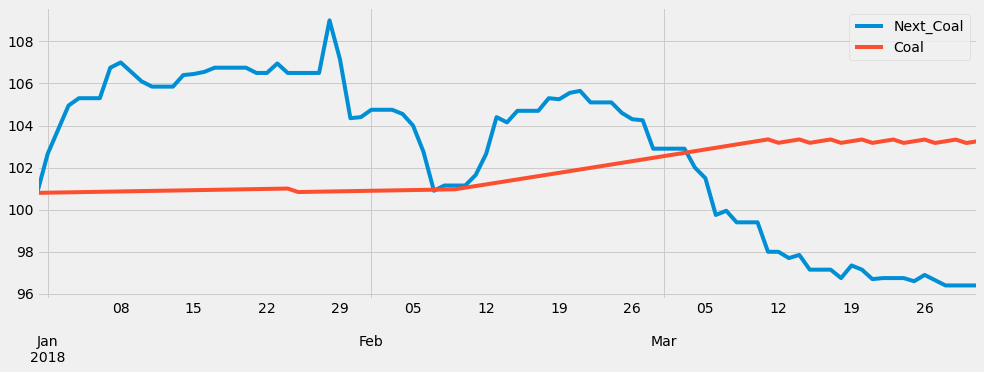

In [ ]:
_ = pd.concat([test_y, df_y_pred['Coal']], axis=1)
#_ = pd.concat([train_y,  _],axis = 1)
print(_)
_ = _.plot(figsize=(15, 5))

# 2018-04-01

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import date, datetime
import datetime
from google.colab import drive
drive.mount('/content/drive/')

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/유연탄 데이터/project/final_df_using_XGB_2018-04-01.csv")
train_end_time = datetime.date(2018, 3, 31)
test_split_date = '2018-03-31'

In [ ]:
df

,Unnamed: 0,Next_Coal,Coal,Iron,Brent_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,ASX,TSX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E
0,2011-01-01,122.65,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
1,2011-01-02,136.50,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
2,2011-01-03,137.30,136.50,170.000000,94.840000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,4745.200195,13443.200195,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932
3,2011-01-04,130.65,137.30,172.100000,93.530000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,4742.500000,13402.299805,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922
4,2011-01-05,133.15,130.65,174.500000,95.500000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,4714.899902,13396.000000,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2018-06-26,114.40,114.75,65.429448,79.191487,73.419464,73.387052,52.403495,1066.389466,1.332922,...,7083.346427,12012.370315,5747.222256,15445.423276,2637.185109,30178.547261,7212.197949,2436.131067,21655.683592,3425.419878
2734,2018-06-27,114.40,114.40,65.380361,79.294033,73.516929,73.485064,52.461466,1066.520380,1.333220,...,7083.653856,12011.400658,5746.067847,15444.922421,2641.935825,30179.526185,7214.898871,2436.019354,21657.998337,3427.681089
2735,2018-06-28,114.40,114.40,65.331274,79.396579,73.614394,73.583076,52.519438,1066.651293,1.333518,...,7083.961285,12010.431001,5746.714580,15444.421567,2640.170958,30180.505109,7217.599793,2435.907641,21660.313082,3427.231984
2736,2018-06-29,114.40,114.40,65.282187,79.499124,73.711859,73.681088,52.561827,1066.782207,1.333815,...,7084.268714,12009.461344,5747.361312,15443.920712,2638.406091,30181.484033,7214.141254,2435.795928,21662.627827,3426.782879


In [ ]:
col_names = df.columns
df['date'] = pd.to_datetime(df[col_names[0]])
df = df.set_index(df['date'])
df = df.drop(['date'],axis = 1)
df = df.drop([col_names[0]],axis = 1)
index = df.index
col_names = df.columns

In [ ]:
period = 90
day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)


test_end_time = train_end_time+ datetime.timedelta(period)
train_end_time = f'{train_end_time.year}-{train_end_time.month}-{train_end_time.day}'
test_end_time = f'{test_end_time.year}-{test_end_time.month}-{test_end_time.day}'
test_end_time = pd.date_range(train_end_time,test_end_time, freq=day_freq)

df = df.loc[df.index <= test_end_time[-1]].copy()

In [ ]:
def create_features(df, label):
    X = df.drop(label, axis = 1)
    y = df[label]
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

In [ ]:
df_X, df_y = create_features(df, col_names[0])
df_y_rate = pd.DataFrame({"y_rate" : ((df_y[col_names[0]]-df_X[col_names[1]])/df_X[col_names[1]])}, index = df_y.index)

#val_split_date = '2017-12-31'
train_X = df_X.loc[df_X.index < test_split_date].copy()
#val_X = train_X.loc[train_X.index > val_split_date].copy()
#train_X = train_X.loc[train_X.index <= val_split_date].copy()
test_X = df_X.loc[df_X.index >= test_split_date].copy()

train_y_rate = df_y_rate.loc[df_y_rate.index < test_split_date].copy()
#val_y_rate = train_y_rate.loc[train_y_rate.index > val_split_date].copy()
#train_y_rate = train_y_rate.loc[train_y_rate.index <= val_split_date].copy()
test_y_rate = df_y_rate.loc[df_y_rate.index >= test_split_date].copy()


train_y = df_y.loc[df_y.index < test_split_date].copy()
test_y = df_y.loc[df_y.index >= test_split_date].copy()



In [ ]:
reg = xgb.XGBRegressor(learning_rate=0.4,max_depth=5,n_estimators=90)
reg.fit(train_X, train_y_rate,
        eval_set=[(train_X, train_y_rate), (test_X, test_y_rate)],
        early_stopping_rounds=100,
        verbose=False)

[07:37:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.4, max_depth=5, n_estimators=90)

In [ ]:
test_X.index[0]

Timestamp('2018-03-31 00:00:00')

In [ ]:
df_y_pred = test_X.head(1)
for i in range(len(test_end_time)-1):
  y_pred = reg.predict(df_y_pred.tail(1))
  y_pred = (1*y_pred+1)*df_y_pred[col_names[1]].tail(1)
  _ = df_y_pred.tail(1).index+datetime.timedelta(days=1)
  _ = pd.date_range(_[0],periods = 1, freq = day_freq)
  frame = pd.DataFrame({col_names[1]:y_pred[0]},index = _)
  q = test_X.loc[test_X.index[i+1]]
  q = pd.DataFrame(q)
  q = q.T.drop('Coal',axis = 1)
  q = pd.concat([frame, q], axis=1)
  df_y_pred = df_y_pred.append(q)

            Next_Coal        Coal
2018-03-31      96.40   96.400000
2018-04-01      92.25   96.328446
2018-04-02      92.00   96.256946
2018-04-03      93.55   96.185499
2018-04-04      94.15   96.114104
...               ...         ...
2018-06-25     114.75  109.036537
2018-06-26     114.40  109.047053
2018-06-27     114.40  109.057569
2018-06-28     114.40  109.068087
2018-06-29     114.40  109.078605

[91 rows x 2 columns]


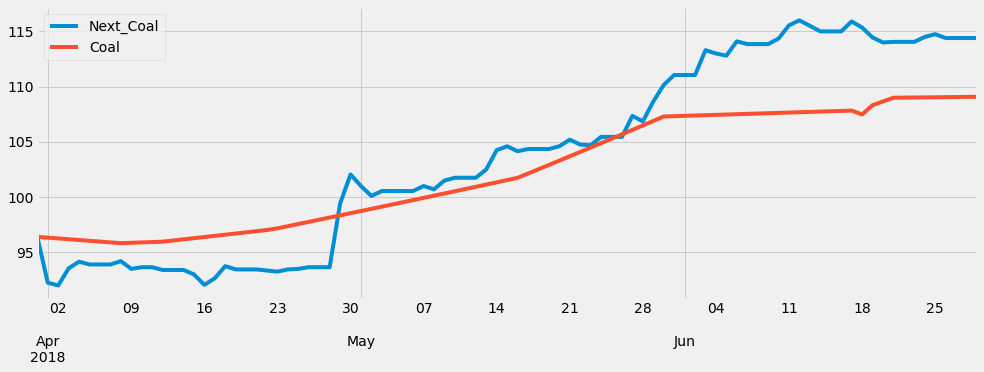

In [ ]:
_ = pd.concat([test_y, df_y_pred['Coal']], axis=1)
#_ = pd.concat([train_y,  _],axis = 1)
print(_)
_ = _.plot(figsize=(15, 5))

# 2018-07-01

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import date, datetime
import datetime
from google.colab import drive
drive.mount('/content/drive/')

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/유연탄 데이터/project/final_df_using_XGB_2018-07-01.csv")
train_end_time = datetime.date(2018, 6, 30)
test_split_date = '2018-06-30'

In [ ]:
df

,Unnamed: 0,Next_Coal,Coal,Iron,Brent_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,ASX,TSX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E
0,2011-01-01,122.65,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
1,2011-01-02,136.50,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
2,2011-01-03,137.30,136.50,170.000000,94.840000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,4745.200195,13443.200195,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932
3,2011-01-04,130.65,137.30,172.100000,93.530000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,4742.500000,13402.299805,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922
4,2011-01-05,133.15,130.65,174.500000,95.500000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,4714.899902,13396.000000,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2824,2018-09-25,113.70,113.70,67.227392,82.007196,82.916878,73.022591,72.317963,1416.318586,1.385896,...,7606.365893,12234.892518,6223.701306,16323.924323,2748.663552,29037.966233,7376.999018,2342.234266,22522.861760,3397.808475
2825,2018-09-26,113.70,113.70,67.255293,82.036704,83.017647,73.019462,72.586623,1416.678569,1.386180,...,7606.014928,12234.075191,6224.035803,16324.455635,2749.205929,29038.918611,7375.466825,2342.419374,22525.371553,3397.833859
2826,2018-09-27,113.85,113.70,67.283194,82.066212,83.118416,73.016333,72.855282,1417.038553,1.386464,...,7605.663962,12233.257863,6224.370299,16324.986946,2749.748307,29039.870988,7373.934633,2342.604482,22527.881346,3397.859243
2827,2018-09-28,113.85,113.85,67.311095,82.095720,83.219184,73.013204,73.123942,1417.398537,1.386748,...,7605.312997,12232.440536,6224.704796,16325.518258,2750.290684,29040.823366,7372.402440,2342.789590,22530.391140,3397.884626


In [ ]:
col_names = df.columns
df['date'] = pd.to_datetime(df[col_names[0]])
df = df.set_index(df['date'])
df = df.drop(['date'],axis = 1)
df = df.drop([col_names[0]],axis = 1)
index = df.index
col_names = df.columns

In [ ]:
period = 90
day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)


test_end_time = train_end_time+ datetime.timedelta(period)
train_end_time = f'{train_end_time.year}-{train_end_time.month}-{train_end_time.day}'
test_end_time = f'{test_end_time.year}-{test_end_time.month}-{test_end_time.day}'
test_end_time = pd.date_range(train_end_time,test_end_time, freq=day_freq)

df = df.loc[df.index <= test_end_time[-1]].copy()

In [ ]:
def create_features(df, label):
    X = df.drop(label, axis = 1)
    y = df[label]
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

In [ ]:
df_X, df_y = create_features(df, col_names[0])
df_y_rate = pd.DataFrame({"y_rate" : ((df_y[col_names[0]]-df_X[col_names[1]])/df_X[col_names[1]])}, index = df_y.index)

#val_split_date = '2017-12-31'
train_X = df_X.loc[df_X.index < test_split_date].copy()
#val_X = train_X.loc[train_X.index > val_split_date].copy()
#train_X = train_X.loc[train_X.index <= val_split_date].copy()
test_X = df_X.loc[df_X.index >= test_split_date].copy()

train_y_rate = df_y_rate.loc[df_y_rate.index < test_split_date].copy()
#val_y_rate = train_y_rate.loc[train_y_rate.index > val_split_date].copy()
#train_y_rate = train_y_rate.loc[train_y_rate.index <= val_split_date].copy()
test_y_rate = df_y_rate.loc[df_y_rate.index >= test_split_date].copy()


train_y = df_y.loc[df_y.index < test_split_date].copy()
test_y = df_y.loc[df_y.index >= test_split_date].copy()



In [ ]:
reg = xgb.XGBRegressor(learning_rate=0.4,max_depth=5,n_estimators=90)
reg.fit(train_X, train_y_rate,
        eval_set=[(train_X, train_y_rate), (test_X, test_y_rate)],
        early_stopping_rounds=100,
        verbose=False)

[07:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.4, max_depth=5, n_estimators=90)

In [ ]:
test_X.index[0]

Timestamp('2018-06-30 00:00:00')

In [ ]:
df_y_pred = test_X.head(1)
for i in range(len(test_end_time)-1):
  y_pred = reg.predict(df_y_pred.tail(1))
  y_pred = (1*y_pred+1)*df_y_pred[col_names[1]].tail(1)
  _ = df_y_pred.tail(1).index+datetime.timedelta(days=1)
  _ = pd.date_range(_[0],periods = 1, freq = day_freq)
  frame = pd.DataFrame({col_names[1]:y_pred[0]},index = _)
  q = test_X.loc[test_X.index[i+1]]
  q = pd.DataFrame(q)
  q = q.T.drop('Coal',axis = 1)
  q = pd.concat([frame, q], axis=1)
  df_y_pred = df_y_pred.append(q)

            Next_Coal        Coal
2018-06-30     114.40  114.400000
2018-07-01     115.00  114.793593
2018-07-02     115.35  115.188540
2018-07-03     116.50  115.449536
2018-07-04     116.60  115.711123
...               ...         ...
2018-09-24     113.70  124.294697
2018-09-25     113.70  124.376414
2018-09-26     113.70  124.458184
2018-09-27     113.85  124.540007
2018-09-28     113.85  124.621885

[91 rows x 2 columns]


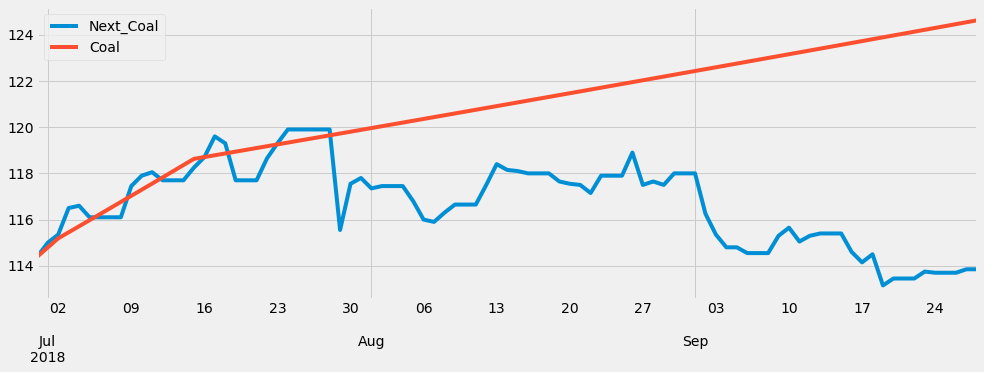

In [ ]:
_ = pd.concat([test_y, df_y_pred['Coal']], axis=1)
#_ = pd.concat([train_y,  _],axis = 1)
print(_)
_ = _.plot(figsize=(15, 5))

# 2018-10-01

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import date, datetime
import datetime
from google.colab import drive
drive.mount('/content/drive/')

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/유연탄 데이터/project/final_df_using_XGB_2018-10-01.csv")
train_end_time = datetime.date(2018, 9, 30)
test_split_date = '2018-09-30'

In [ ]:
df

,Unnamed: 0,Next_Coal,Coal,Iron,Brent_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,ASX,TSX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E
0,2011-01-01,122.65,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
1,2011-01-02,136.50,122.65,168.300000,94.750000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
2,2011-01-03,137.30,136.50,170.000000,94.840000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,4745.200195,13443.200195,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932
3,2011-01-04,130.65,137.30,172.100000,93.530000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,4742.500000,13402.299805,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922
4,2011-01-05,133.15,130.65,174.500000,95.500000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,4714.899902,13396.000000,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2018-12-26,101.55,101.00,67.007266,78.002964,72.142469,73.110505,74.673497,1535.949812,1.394116,...,7533.521879,12205.972393,6178.765691,16060.077178,2885.897316,27820.235223,7994.563475,2333.409599,23693.533594,3431.035008
2917,2018-12-27,101.90,101.55,66.797289,77.991645,72.129739,73.107072,74.270899,1542.025739,1.394124,...,7533.789945,12205.503910,6178.434261,16059.927495,2885.574526,27820.599771,7989.007347,2333.298559,23691.212742,3430.846848
2918,2018-12-28,101.90,101.90,66.919151,77.980326,72.117009,73.103639,74.575230,1548.101665,1.394132,...,7534.058010,12205.035426,6178.102831,16059.777812,2885.251737,27820.964319,7989.530043,2333.187519,23688.891890,3430.658689
2919,2018-12-29,101.90,101.90,67.041012,77.969007,72.104278,73.100206,74.172632,1539.379667,1.394140,...,7534.326075,12204.566942,6177.771401,16059.628129,2884.928948,27821.328867,7990.052739,2333.076479,23686.571037,3430.470529


In [ ]:
col_names = df.columns
df['date'] = pd.to_datetime(df[col_names[0]])
df = df.set_index(df['date'])
df = df.drop(['date'],axis = 1)
df = df.drop([col_names[0]],axis = 1)
index = df.index
col_names = df.columns

In [ ]:
period = 90
day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)


test_end_time = train_end_time+ datetime.timedelta(period)
train_end_time = f'{train_end_time.year}-{train_end_time.month}-{train_end_time.day}'
test_end_time = f'{test_end_time.year}-{test_end_time.month}-{test_end_time.day}'
test_end_time = pd.date_range(train_end_time,test_end_time, freq=day_freq)

df = df.loc[df.index <= test_end_time[-1]].copy()

In [ ]:
def create_features(df, label):
    X = df.drop(label, axis = 1)
    y = df[label]
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

In [ ]:
df_X, df_y = create_features(df, col_names[0])
df_y_rate = pd.DataFrame({"y_rate" : ((df_y[col_names[0]]-df_X[col_names[1]])/df_X[col_names[1]])}, index = df_y.index)

#val_split_date = '2017-12-31'
train_X = df_X.loc[df_X.index < test_split_date].copy()
#val_X = train_X.loc[train_X.index > val_split_date].copy()
#train_X = train_X.loc[train_X.index <= val_split_date].copy()
test_X = df_X.loc[df_X.index >= test_split_date].copy()

train_y_rate = df_y_rate.loc[df_y_rate.index < test_split_date].copy()
#val_y_rate = train_y_rate.loc[train_y_rate.index > val_split_date].copy()
#train_y_rate = train_y_rate.loc[train_y_rate.index <= val_split_date].copy()
test_y_rate = df_y_rate.loc[df_y_rate.index >= test_split_date].copy()


train_y = df_y.loc[df_y.index < test_split_date].copy()
test_y = df_y.loc[df_y.index >= test_split_date].copy()



In [ ]:
reg = xgb.XGBRegressor(learning_rate=0.4,max_depth=5,n_estimators=90)
reg.fit(train_X, train_y_rate,
        eval_set=[(train_X, train_y_rate), (test_X, test_y_rate)],
        early_stopping_rounds=100,
        verbose=False)

[07:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.4, max_depth=5, n_estimators=90)

In [ ]:
test_X.index[0]

Timestamp('2018-09-30 00:00:00')

In [ ]:
df_y_pred = test_X.head(1)
for i in range(len(test_end_time)-1):
  y_pred = reg.predict(df_y_pred.tail(1))
  y_pred = (1*y_pred+1)*df_y_pred[col_names[1]].tail(1)
  _ = df_y_pred.tail(1).index+datetime.timedelta(days=1)
  _ = pd.date_range(_[0],periods = 1, freq = day_freq)
  frame = pd.DataFrame({col_names[1]:y_pred[0]},index = _)
  q = test_X.loc[test_X.index[i+1]]
  q = pd.DataFrame(q)
  q = q.T.drop('Coal',axis = 1)
  q = pd.concat([frame, q], axis=1)
  df_y_pred = df_y_pred.append(q)

            Next_Coal        Coal
2018-09-30     114.60  113.850000
2018-10-01     114.05  113.903664
2018-10-02     113.90  113.957352
2018-10-03     113.75  114.011067
2018-10-04     113.65  114.064806
...               ...         ...
2018-12-25     101.00  136.202887
2018-12-26     101.55  137.068398
2018-12-27     101.90  135.254334
2018-12-28     101.90  136.113818
2018-12-29     101.90  136.978762

[91 rows x 2 columns]


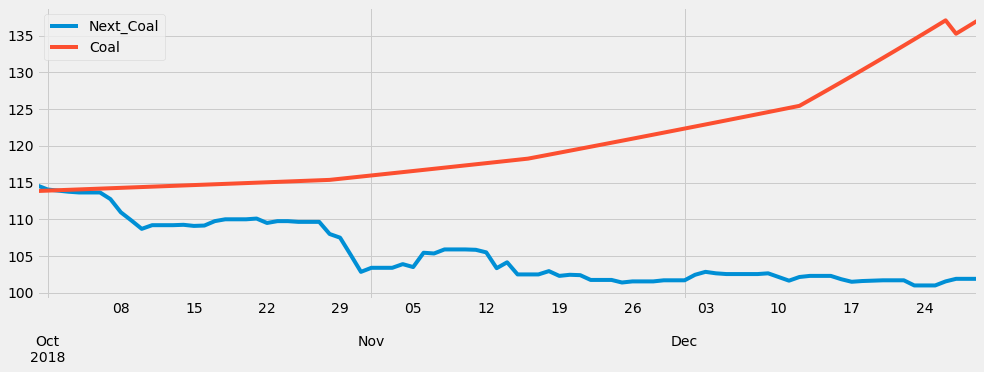

In [ ]:
_ = pd.concat([test_y, df_y_pred['Coal']], axis=1)
#_ = pd.concat([train_y,  _],axis = 1)
print(_)
_ = _.plot(figsize=(15, 5))

# 실험

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import date, datetime
import datetime
from google.colab import drive
drive.mount('/content/drive/')

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/유연탄 데이터/project/project_dataset.csv")

In [ ]:
period = 90

day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)

df['date'] = pd.to_datetime(df['date'])
df = df.set_index(df['date'])
df = df.drop(['date'],axis = 1)
_ = pd.DataFrame({'weekly': 0}, index = pd.date_range(df.head(1).index[0], df.tail(1).index[0], freq=day_freq))
_ = pd.concat([df, _], axis = 1)
_
_ = _.dropna()
df = _.drop('weekly',axis = 1)
df

,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),USD/CAD(캐나다),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
2011-01-01,122.65,168.30,94.75,"9,644.00",91.38,91.40,61.07,1773.0,0.984470,0.99960,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2011-01-02,122.65,168.30,94.75,"9,644.00",91.38,91.40,61.07,1773.0,0.984470,0.99960,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2011-01-03,136.50,170.00,94.84,"9,644.00",91.55,91.56,61.07,1773.0,0.979010,0.99270,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
2011-01-04,137.30,172.10,93.53,"9,619.25",89.38,89.23,58.32,1693.0,0.983370,0.99239,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
2011-01-05,130.65,174.50,95.50,"9,586.00",90.30,90.38,56.40,1621.0,0.992850,0.99700,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,79.85,155.02,51.29,"7,787.50",48.23,47.93,51.07,1366.0,1.314613,1.28482,...,6502.100098,13587.230469,3703.060059,26386.560547,12804.730469,2806.860107,26656.609375,3539.260010,6664.799805,17623.900391
2020-12-28,85.35,155.35,50.86,"7,787.50",47.62,47.87,51.07,1366.0,1.313730,1.28396,...,6502.100098,13790.290039,3735.360107,26314.630859,12899.419922,2808.600098,26854.029297,3575.409912,6664.799805,17623.900391
2020-12-29,84.20,155.57,51.09,"7,859.50",48.00,47.94,55.51,1366.0,1.317710,1.28400,...,6602.700195,13761.379883,3727.040039,26568.490234,12850.219727,2820.510010,27568.150391,3581.370117,6700.299805,17543.400391
2020-12-30,81.60,155.70,51.34,"7,847.50",48.40,48.22,55.82,1366.0,1.314078,1.28221,...,6555.799805,13718.780273,3732.040039,27147.109375,12870.000000,2873.469971,27444.169922,3571.590088,6682.399902,17545.800781


In [ ]:
df['next_coal_price'] = df['Coal_price'].shift(-1)
df = df.dropna()
#df = df.drop(['Coal_price'],axis = 1)
df= df[['next_coal_price', 'Coal_price', 'iron', 'Brent_fut', 'WTI_fut', 'WTI', 
        'LNG_fut', 'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'USD/IDR(인도네시아)', 
        'USD/RUB(러시아)', 'USD/ZAR(자메이카)', 'US 달러지수', '상하이종합지수', '인도지수', '브라질지수', 
        '다우존스지수', '프랑스지수', '영국지수', '독일지수', '호주지수', '캐나다지수', 
        'S&P500지수', '항셍지수', '나스닥지수', '코스피지수', '니케이225지수', '유로스톡스50지수']]
df.columns = ['Next_Coal', 'Coal', 'Iron', 'Brent_fut', 'WTI_fut', 'WTI', 
              'LNG_fut', 'BDI', 'AUD_dollar', 'CAD_dollor', 'COP_dollor', 'IDR_dollor', 
              'RUB_dollor', 'ZAR_dollor', 'DXY' , 'SHA', 'BSE', 'BVSP', 
              'DJI', 'CAC', 'FTSE', 'DAX', 'ASX', 'TSX', 
              'S&P500', 'HSI', 'IXIC', 'KOSPI', 'Nikkei225', 'SX5E']
df.head()

,Next_Coal,Coal,Iron,Brent_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,...,FTSE,DAX,ASX,TSX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E
2011-01-01,122.65,122.65,168.3,94.75,91.38,91.40,61.07,1773.0,0.98447,0.99960,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
2011-01-02,136.50,122.65,168.3,94.75,91.38,91.40,61.07,1773.0,0.98447,0.99960,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
2011-01-03,137.30,136.50,170.0,94.84,91.55,91.56,61.07,1773.0,0.97901,0.99270,...,5899.899902,6989.740234,4745.200195,13443.200195,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932
2011-01-04,130.65,137.30,172.1,93.53,89.38,89.23,58.32,1693.0,0.98337,0.99239,...,6013.899902,6975.350098,4742.500000,13402.299805,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922
2011-01-05,133.15,130.65,174.5,95.50,90.30,90.38,56.40,1621.0,0.99285,0.99700,...,6043.899902,6939.819824,4714.899902,13396.000000,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990


In [ ]:
period = 90
day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)


test_end_time = train_end_time+ datetime.timedelta(period)
train_end_time = f'{train_end_time.year}-{train_end_time.month}-{train_end_time.day}'
test_end_time = f'{test_end_time.year}-{test_end_time.month}-{test_end_time.day}'
test_end_time = pd.date_range(train_end_time,test_end_time, freq=day_freq)

df = df.loc[df.index <= test_end_time[-1]].copy()

TypeError: ignored

In [ ]:
def create_features(df, label):
    X = df.drop(label, axis = 1)
    y = df[label]
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

In [ ]:
df = df.drop('Coal',axis = 1)

In [ ]:
index = df.index
col_names = df.columns

In [ ]:
df_X, df_y = create_features(df, col_names[0])
df_y_rate = pd.DataFrame({"y_rate" : ((df_y[col_names[0]]-df_X[col_names[1]])/df_X[col_names[1]])}, index = df_y.index)

#val_split_date = '2017-12-31'
train_X = df_X.loc[df_X.index < test_split_date].copy()
#val_X = train_X.loc[train_X.index > val_split_date].copy()
#train_X = train_X.loc[train_X.index <= val_split_date].copy()
test_X = df_X.loc[df_X.index >= test_split_date].copy()

train_y_rate = df_y_rate.loc[df_y_rate.index < test_split_date].copy()
#val_y_rate = train_y_rate.loc[train_y_rate.index > val_split_date].copy()
#train_y_rate = train_y_rate.loc[train_y_rate.index <= val_split_date].copy()
test_y_rate = df_y_rate.loc[df_y_rate.index >= test_split_date].copy()


train_y = df_y.loc[df_y.index < test_split_date].copy()
test_y = df_y.loc[df_y.index >= test_split_date].copy()



In [ ]:
reg = xgb.XGBRegressor(learning_rate=0.4,max_depth=5,n_estimators=90)
reg.fit(train_X, train_y_rate,
        eval_set=[(train_X, train_y_rate), (test_X, test_y_rate)],
        early_stopping_rounds=100,
        verbose=False)

[08:07:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.4, max_depth=5, n_estimators=90)

In [ ]:
test_X.index[0]

Timestamp('2017-06-30 00:00:00')

In [ ]:
qqq = test_y.index

In [ ]:
y_pred = reg.predict(test_X)
y_pred
a = test_y.head(1)
b = []
for i in range(len(y_pred)):
   b = np.append(b , a) 
   a = a*(1+y_pred[i])
b = pd.DataFrame(b , index = qqq)
b


,0
date,
2017-06-30,8.100000e+01
2017-07-01,1.233052e+02
2017-07-02,1.877058e+02
2017-07-03,2.857420e+02
2017-07-04,4.349812e+02
...,...
2017-09-24,1.230188e+13
2017-09-25,1.596005e+13
2017-09-26,2.070602e+13


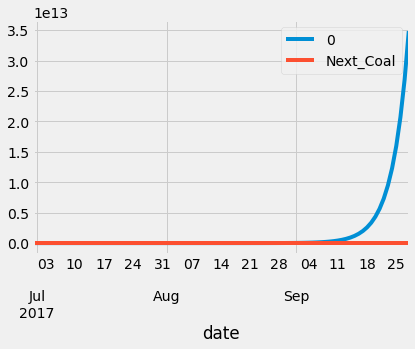

In [ ]:
_ = pd.concat([b,  test_y],axis = 1)
_.plot()

In [ ]:
df_y_pred = test_X.head(1)
for i in range(len(test_end_time)-1):
  y_pred = reg.predict(df_y_pred.tail(1))
  y_pred = (1*y_pred+1)*df_y_pred[col_names[1]].tail(1)
  _ = df_y_pred.tail(1).index+datetime.timedelta(days=1)
  _ = pd.date_range(_[0],periods = 1, freq = day_freq)
  frame = pd.DataFrame({col_names[1]:y_pred[0]},index = _)
  q = test_X.loc[test_X.index[i+1]]
  q = pd.DataFrame(q)
  q = q.T.drop('Coal',axis = 1)
  q = pd.concat([frame, q], axis=1)
  df_y_pred = df_y_pred.append(q)

            Next_Coal       Coal
2017-06-30      81.00  81.000000
2017-07-01      81.00  81.553527
2017-07-02      79.45  82.110838
2017-07-03      81.15  82.671956
2017-07-04      83.05  83.236909
...               ...        ...
2017-09-24      96.95  98.878034
2017-09-25      97.00  98.375658
2017-09-26      97.25  98.784425
2017-09-27      97.10  99.194890
2017-09-28      97.25  99.607060

[91 rows x 2 columns]


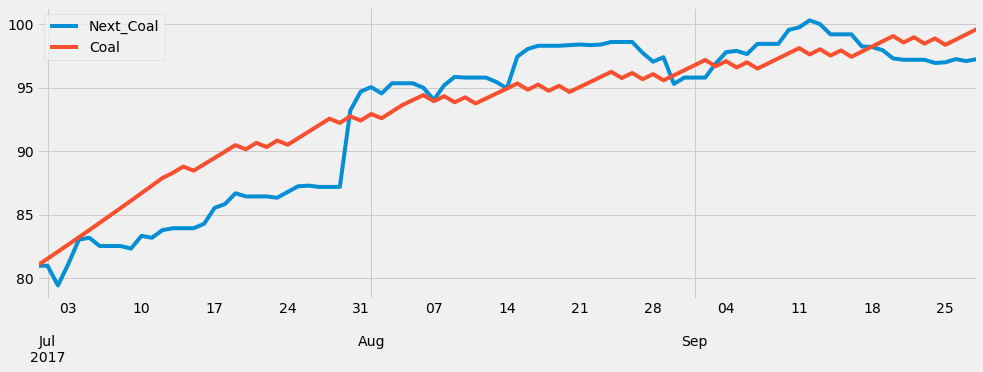

In [ ]:
_ = pd.concat([test_y, df_y_pred['Coal']], axis=1)
#_ = pd.concat([train_y,  _],axis = 1)
print(_)
_ = _.plot(figsize=(15, 5))